In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 10000)
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(12, 7) 
import scipy
import seaborn as sns
from sklearn.model_selection import train_test_split , StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn import metrics
from IPython.display import clear_output #for live updating training plot
from scipy import stats #for least squares slope feature
from tqdm import tqdm

In [2]:
import keras
from keras.utils import np_utils
from __future__ import print_function
from keras.utils.np_utils import to_categorical

from keras.preprocessing import sequence
from keras.models import Sequential, load_model, Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense,MaxPooling1D,Conv1D,Conv2D, Masking,Embedding, Convolution1D,TimeDistributed, GlobalMaxPooling1D,Dropout, Flatten, LSTM, GRU, Bidirectional, Input, Merge,Activation, regularizers
from keras import backend as K
from keras.optimizers import Adam, Nadam

Using Theano backend.
Using cuDNN version 6021 on context None
Mapped name None to device cuda1: GRID K2 (0000:07:00.0)


In [3]:
np.random.seed(42)

## Microphone

In [83]:
mic = pd.read_csv('/home/ds806/rds/rds-cm542-mobile-systems/project/data/features/moodMic30min/moodMic_2Days_97samples_1.txt', sep="\t",dtype={0:str}, header=None, error_bad_lines=False)
mic = mic.iloc[:,0:52]
print (mic.shape)
mic = mic.dropna(axis=0, thresh=7).reset_index(drop=True)
print (mic.shape)

(414496, 52)
(263904, 52)


In [84]:
#minmax scaling [0.05, 1] BY ROW and replace nans with zero 
mic_array = mic.values #convert df to numpy array
for i in tqdm(range(mic_array.shape[0])):
    mic_array[i,4:]  = ((mic_array[i,4:] - np.nanmin(mic_array[i,4:])) / (np.nanmax(mic_array[i,4:] ) - np.nanmin(mic_array[i,4:]))) * (1.00 - 0.05) + 0.05
mic = pd.DataFrame(mic_array).fillna(0)    

100%|██████████| 263904/263904 [00:40<00:00, 6596.58it/s]


In [85]:
mic.describe()

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51
count,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000,263904.000000
mean,0.578421,0.474346,0.124475,0.122628,0.119805,0.115614,0.112053,0.106901,0.101479,0.095913,0.090387,0.083897,0.078527,0.073555,0.068349,0.063142,0.057871,0.053649,0.048654,0.044456,0.040361,0.037039,0.034007,0.031033,0.028860,0.027881,0.026988,0.026927,0.027638,0.028819,0.030854,0.033951,0.037409,0.040473,0.044742,0.049298,0.054034,0.058667,0.064204,0.070911,0.076377,0.080154,0.083411,0.086269,0.146166,0.228097,0.235906,0.244511,0.250493,0.265014
std,0.230281,0.232758,0.244884,0.240202,0.236744,0.231471,0.228721,0.223524,0.218270,0.213521,0.208019,0.200735,0.195368,0.189923,0.183614,0.176258,0.168983,0.163413,0.155074,0.148897,0.141643,0.135680,0.130105,0.123175,0.118639,0.117175,0.114705,0.114468,0.116231,0.118735,0.122656,0.130264,0.136979,0.141906,0.149513,0.156991,0.163898,0.169995,0.177640,0.187380,0.194866,0.199661,0.204157,0.208394,0.260099,0.300593,0.302911,0.307170,0.311308,0.322118
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.415000,0.290000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.050000,0.050091,0.050184,0.050552
50%,0.613000,0.454000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.080369,0.086771,0.092886,0.096255,0.103055
75%,0.760000,0.658000,0.105261,0.106300,0.102935,0.098382,0.092803,0.086198,0.078890,0.072032,0.065566,0.059292,0.055158,0.052074,0.050327,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.050863,0.052686,0.054785,0.056535,0.057793,0.138452,0.294798,0.314874,0.334456,0.345132,0.372541
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fec6d7c5be0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fec6e28a908>]], dtype=object)

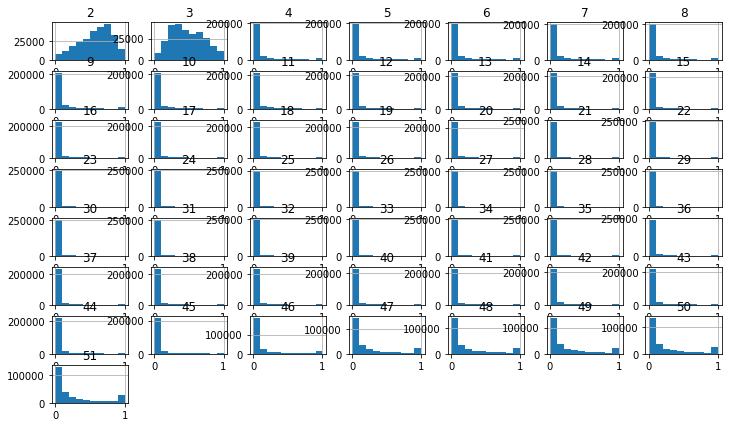

In [86]:
mic.hist()

In [ ]:
#fill row nan with mean of row
#mic = pd.concat([mic[[0,1,2,3]], mic.iloc[:,4:].apply(lambda row: row.fillna(row.mean()), axis=1)], axis=1)
#mic.shape

In [ ]:
#fill nan with 'mean of mean' of all columns
#mic = pd.concat([mic[[0,1,2,3]],mic.iloc[:,4:].fillna(mic.iloc[:,4:].describe().T["mean"].mean())], axis=1)
#mic.shape

In [12]:
#normalize values by dividing each one with the sum of the row while log-transforming, and concat the label/timstamp
mic_norm = pd.concat([mic[[0,1,2,3]],np.log(mic.iloc[:,4:]+10)], axis=1)
mic_norm.shape

(72926, 52)

In [13]:
mic_norm.describe()

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51
count,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000,72926.000000
mean,0.566523,0.478125,2.319918,2.320369,2.320498,2.320371,2.319948,2.319452,2.318837,2.318251,2.317498,2.316793,2.316223,2.315707,2.315213,2.314609,2.314034,2.313523,2.312643,2.312014,2.311247,2.310621,2.310060,2.309418,2.308977,2.308656,2.308560,2.308496,2.308560,2.308755,2.308937,2.309351,2.309905,2.310235,2.310818,2.311410,2.312021,2.312533,2.313151,2.313885,2.314411,2.314542,2.314501,2.314430,2.318160,2.324010,2.324452,2.324814,2.324981,2.325319
std,0.228997,0.230537,0.024430,0.024292,0.024194,0.024046,0.023798,0.023593,0.023411,0.023293,0.022862,0.022446,0.022194,0.021967,0.021691,0.021154,0.020719,0.020394,0.019480,0.019149,0.018309,0.017740,0.017129,0.016270,0.015811,0.015427,0.015384,0.015286,0.015356,0.015662,0.015828,0.016517,0.017279,0.017493,0.018174,0.018799,0.019313,0.019699,0.020125,0.020847,0.021375,0.021515,0.021483,0.021660,0.023361,0.024981,0.025176,0.025386,0.025462,0.025828
min,0.000000,0.000000,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585
25%,0.402000,0.295000,2.302585,2.307573,2.307573,2.307576,2.307573,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.308115,2.308205,2.308305,2.308376,2.308454
50%,0.600000,0.461000,2.309692,2.310106,2.310234,2.310152,2.309921,2.309565,2.309165,2.308816,2.308496,2.308189,2.308003,2.307821,2.307706,2.307631,2.307591,2.307573,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,2.307573,2.307577,2.307580,2.307573,2.302585,2.308721,2.312219,2.312570,2.312857,2.312990,2.313241
75%,0.748000,0.661000,2.322594,2.323611,2.323681,2.323421,2.322644,2.322061,2.320808,2.319850,2.318876,2.317756,2.316786,2.315985,2.315055,2.314242,2.313318,2.312575,2.311518,2.310536,2.309768,2.309176,2.308725,2.308310,2.308059,2.307938,2.307878,2.307870,2.307893,2.307959,2.308046,2.308233,2.308528,2.308934,2.309426,2.310159,2.310837,2.311517,2.312444,2.313352,2.313957,2.314229,2.314288,2.314054,2.319680,2.329022,2.329758,2.330546,2.330840,2.331096
max,1.000000,1.000000,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895


In [ ]:
mic.isnull().values.any()

## Accelerometer

In [90]:
acc = pd.read_csv('/home/ds806/rds/rds-cm542-mobile-systems/project/data/features/moodAcc30min/moodAcc_2Days_97samples_1.txt', sep="\t",dtype={0:str}, header=None, error_bad_lines=False)
acc = acc.iloc[:,0:52]
print (acc.shape)
acc = acc.dropna(axis=0, thresh=7).reset_index(drop=True)
print (acc.shape)
#acc = acc.loc[(acc.iloc[:,4:] < 10000).all(axis=1)].reset_index(drop=True) #remove rows when at least one value is over 20
print (acc.shape)

b'Skipping line 724964: expected 101 fields, saw 147\n'


(905921, 52)
(710962, 52)
(710962, 52)


In [91]:
#minmax scaling [0.05, 1] BY ROW and replace nans with zero 
acc_array = acc.values #convert df to numpy array
for i in tqdm(range(acc_array.shape[0])):
    acc_array[i,4:]  = ((acc_array[i,4:] - np.nanmin(acc_array[i,4:])) / (np.nanmax(acc_array[i,4:] ) - np.nanmin(acc_array[i,4:]))) * (1.00 - 0.05) + 0.05
acc = pd.DataFrame(acc_array).fillna(0)  

100%|██████████| 710962/710962 [01:49<00:00, 6519.21it/s]


In [ ]:
#fill nan with 'mean of mean' of all columns
#acc = pd.concat([acc[[0,1,2,3]],acc.iloc[:,4:].fillna(acc.iloc[:,4:].describe().T["mean"].mean())], axis=1)

#fill row nan with mean of row
#acc = pd.concat([acc[[0,1,2,3]], acc.iloc[:,4:].apply(lambda row: row.fillna(row.mean()), axis=1)], axis=1)

#acc.shape

In [ ]:
#normalize values by dividing each one with the sum of the row, and concat the label/timstamp
#acc_norm = pd.concat([acc[[0,1,2,3]],np.log((acc.iloc[:,4:]+20).div((acc.iloc[:,4:]+20).sum(axis=1), axis=0))], axis=1)
#acc_norm.shape

## Merge

In [92]:
merged = pd.merge(mic, acc, on=[0,1,2,3])  #merge on userid, timestamp

In [93]:
merged.shape

(253124, 100)

In [94]:
merged.head()

,0,1,2,3,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,20_x,21_x,22_x,23_x,24_x,25_x,26_x,27_x,28_x,29_x,30_x,31_x,32_x,33_x,34_x,35_x,36_x,37_x,38_x,39_x,40_x,41_x,42_x,43_x,44_x,45_x,46_x,47_x,48_x,49_x,50_x,51_x,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,12_y,13_y,14_y,15_y,16_y,17_y,18_y,19_y,20_y,21_y,22_y,23_y,24_y,25_y,26_y,27_y,28_y,29_y,30_y,31_y,32_y,33_y,34_y,35_y,36_y,37_y,38_y,39_y,40_y,41_y,42_y,43_y,44_y,45_y,46_y,47_y,48_y,49_y,50_y,51_y
0,012379001668718,2013-12-02 14:49:13 +0000,0.208,0.717,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.083150,1.00,0.064353,0.080986,0.050000,0.499310,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00,0.00,0.000000,0.0,0.05,0.081934,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.237028,0.0,0.0
1,012379001668718,2013-12-02 16:20:37 +0000,0.187,0.712,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.08315,1.0,0.064353,0.080986,0.05,0.499310,0.000000,0.105082,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00,0.05,0.081934,0.0,0.00,0.000000,0.0,0.0,0.0,1.0,0.0,0.237028,0.0,0.0,0.000000,0.0,0.0
2,012379001668718,2013-12-04 09:47:35 +0000,0.197,0.245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.677977,1.00000,0.281180,0.419997,0.160043,0.234281,0.768081,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.00,0.000000,0.352291,0.085938,0.125486,0.126435,0.0,0.0,0.0,0.000000,0.076327,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.05,0.0,0.0,0.0,0.0,0.0,0.000000,0.240342,0.0,0.00,0.00,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,1.0
3,012379001668718,2013-12-04 10:24:58 +0000,0.181,0.744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.677977,1.000000,0.28118,0.419997,0.160043,0.234281,0.768081,0.050000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.00,0.352291,0.085938,0.125486,0.079280,0.000000,0.0,0.0,0.0,0.076327,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.00,0.0,0.0,0.0,0.0,0.0,0.240342,0.000000,0.0,0.00,0.00,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.0,0.0
4,012379001668718,2013-12-05 16:53:07 +0000,0.277,0.723,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,1.00,0.097397,0.050000,0.111171,0.067875,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.239529,0.0,1.0,0.426069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.05,0.00,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


In [95]:
merged["month_number"] = pd.to_datetime(merged[1]).apply(lambda x: x.month)
merged["week_number"] = pd.to_datetime(merged[1]).apply(lambda x: x.weekofyear)
merged["quarter_number"] = pd.to_datetime(merged[1]).apply(lambda x: x.quarter)
merged["dayofweek_number"] = pd.to_datetime(merged[1]).apply(lambda x: x.dayofweek)
merged["hourofday_number"] = pd.to_datetime(merged[1]).apply(lambda x: x.hour)

In [ ]:
#personality = pd.read_csv('personality_12k_one_hot.csv', sep="\t", index_col=0,dtype={'userId':str},error_bad_lines=False)
#personality = personality.rename(columns={'userId': "0"})

In [ ]:
#display(personality.head(), merged.head())

In [ ]:
#merged = pd.merge(merged,personality, on=["0"])

In [ ]:
#merged.shape

In [ ]:
#gps = pd.read_csv('/home/ds806/rds/rds-cm542-mobile-systems/project/data/features/moodLoc60min/moodLocFeaturesWithHeader.txt', sep="\t",dtype={'uid':str},error_bad_lines=False)
#gps = gps.rename(columns={'uid': "0", 'timeMood': "1"})
#gps.head()

In [ ]:
#merged = pd.merge(gps,merged, on=["0","1"])

In [ ]:
#merged.shape

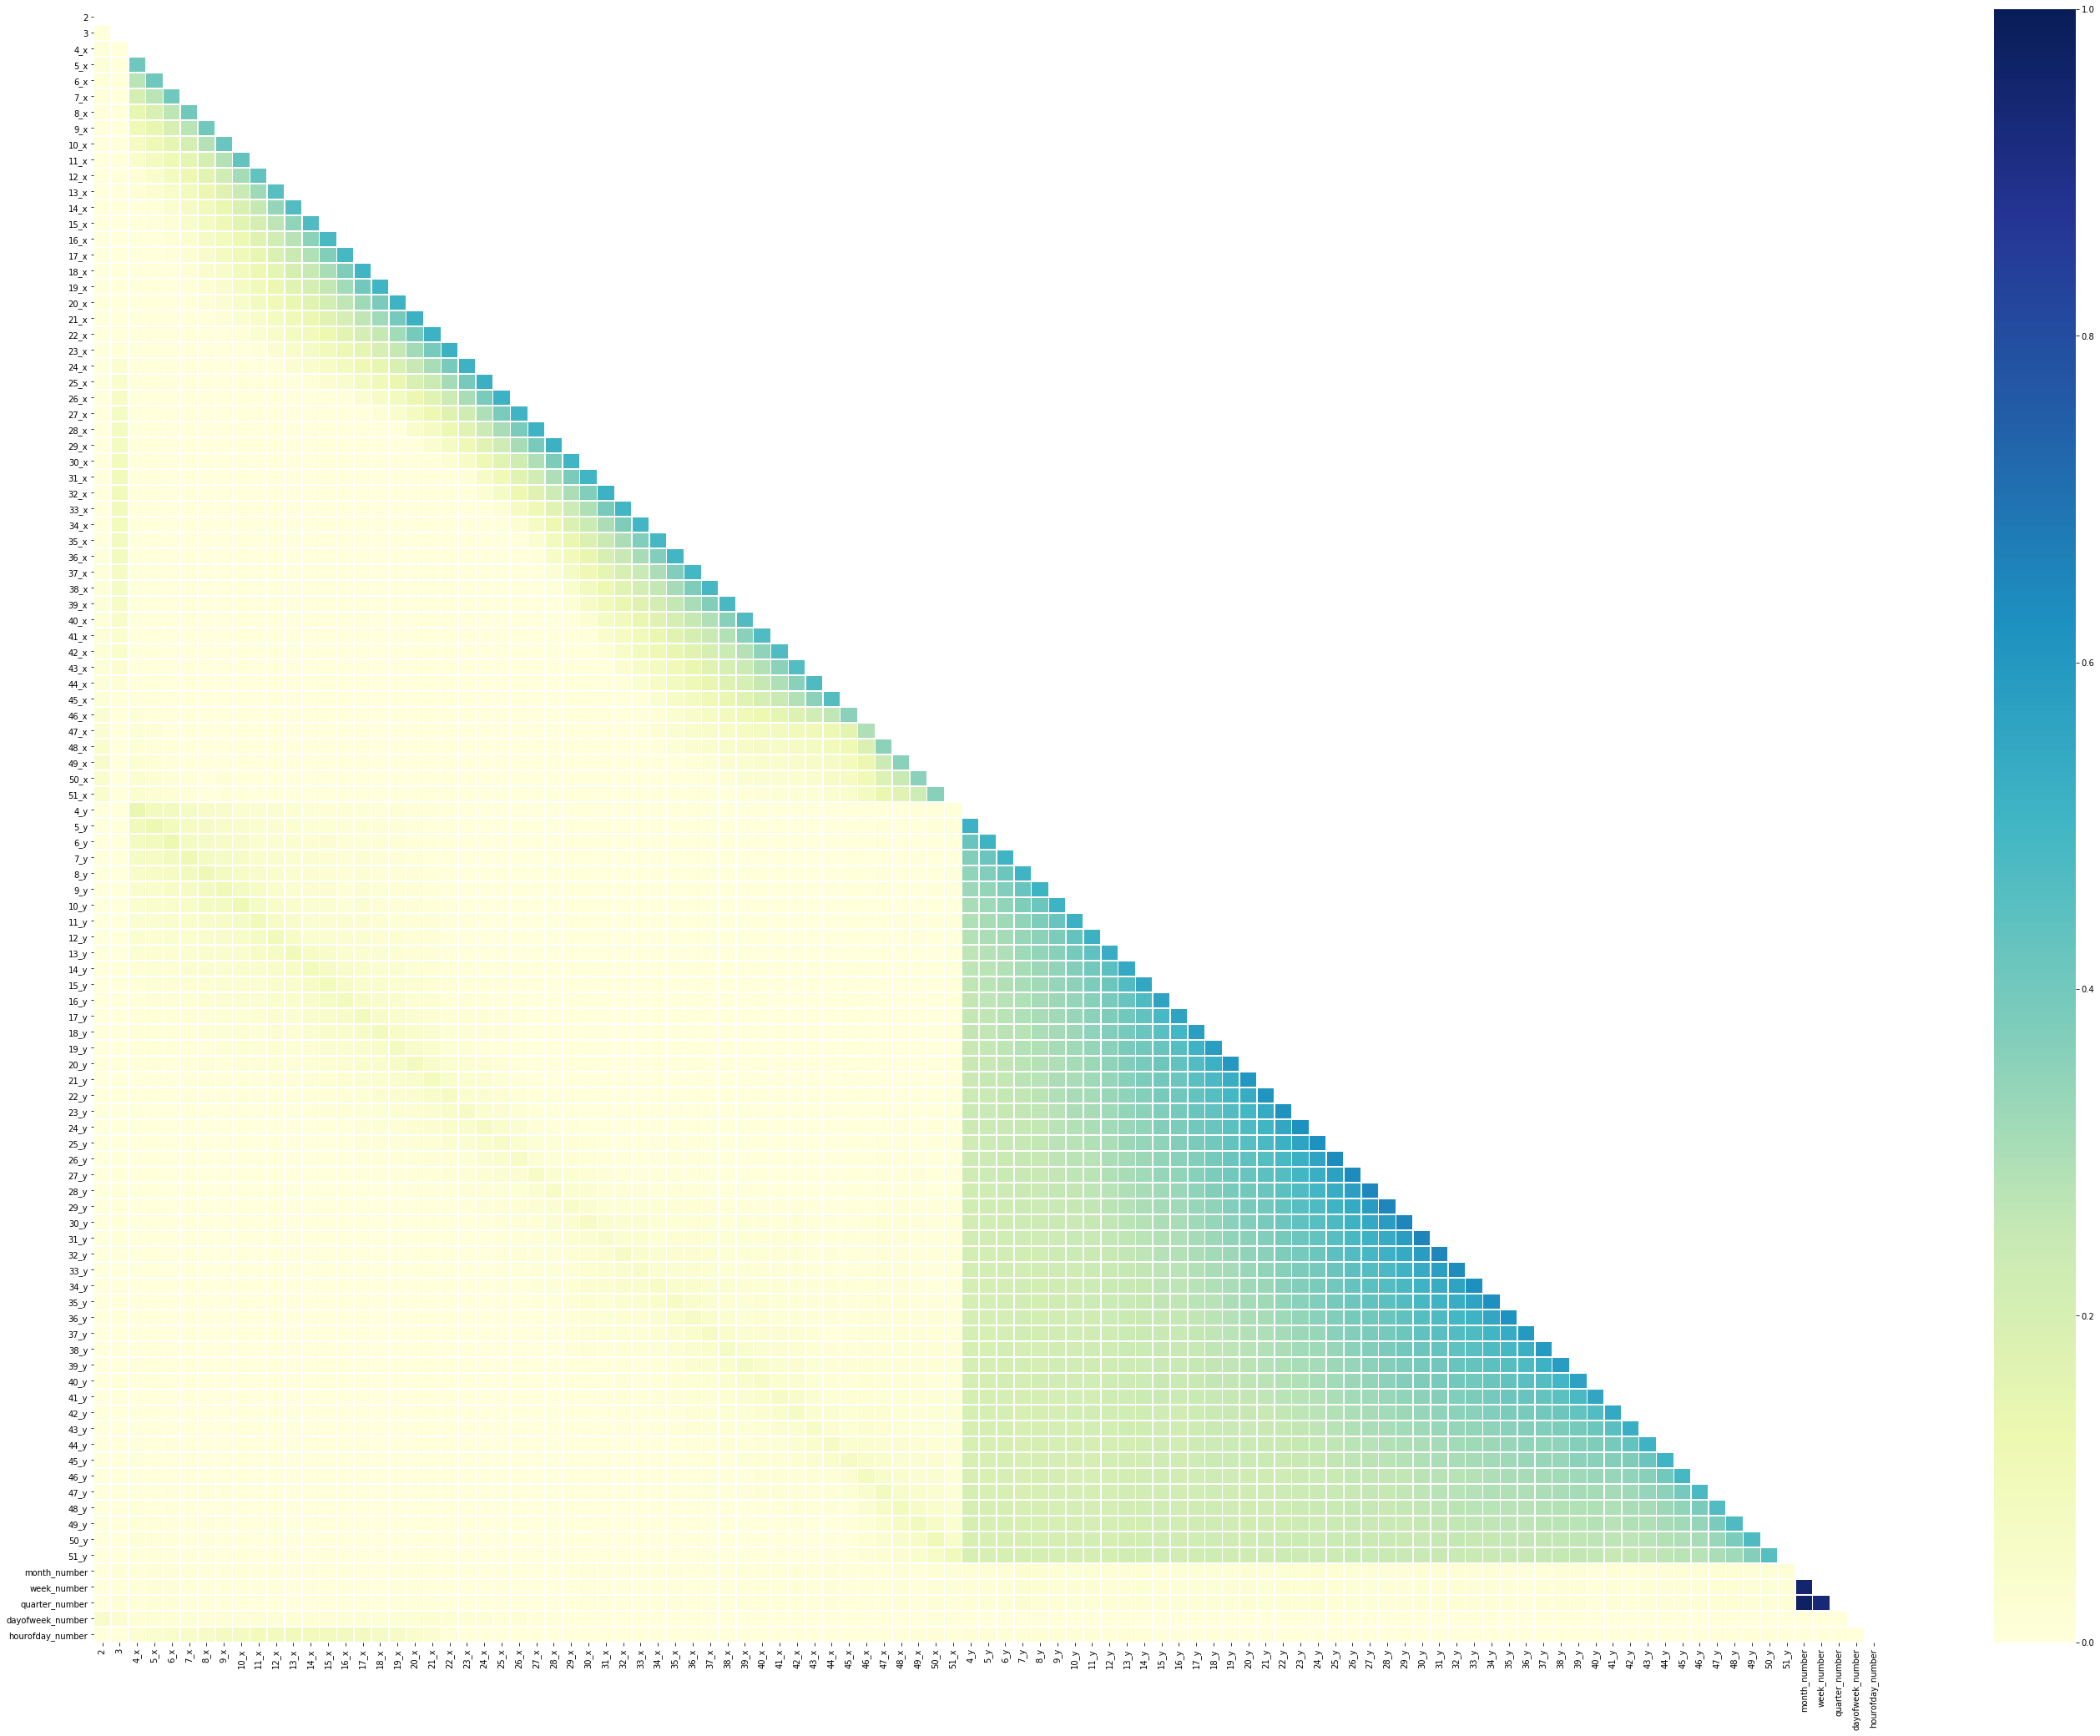

In [21]:
corrmat = merged.corr()
f, ax = plt.subplots(figsize=(48, 36))
mask = np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmin=0,mask=mask, linewidths=.5,vmax=1, cmap="YlGnBu")

In [96]:
center_values = (merged[2] >= 0.45) & (merged[2] <= 0.55) & (merged[3] >= 0.45) & (merged[3] <= 0.55)

In [97]:
"""
merged['label1'] = np.where((merged["2"] > 0.55) & (merged["3"] > 0.55) & (~center_values), 1, 0)
merged['label2'] = np.where((merged["2"] < 0.45) & (merged["3"] < 0.45) & (~center_values), 1, 0)
merged['label3'] = np.where((merged["2"] > 0.55) & (merged["3"] < 0.45) & (~center_values), 1, 0)
merged['label4'] = np.where((merged["2"] < 0.45) & (merged["3"] > 0.55) & (~center_values), 1, 0)

merged['label5'] = np.where((merged['label1']==0) 
                            & (merged['label2']==0) 
                            & (merged['label3']==0)
                            & (merged['label4']==0), 1, 0)

"""

#binary 

merged['label1'] = np.where((merged[2] > 0.55) & (~center_values), 1, 0)
merged['label2'] = np.where((merged[2] < 0.45) & (~center_values), 1, 0)
merged['label3'] = np.where((merged['label1']==0) 
                            & (merged['label2']==0), 1, 0)


In [98]:
y = merged[["label1", "label2", 'label3']].values 
y.shape

(253124, 3)

In [99]:
y = np.argmax(y, axis=1) 
y.shape

(253124,)

In [100]:
merged['label_final'] = y

In [101]:
merged.label_final.value_counts()

0    148366
1     70675
2     34083
Name: label_final, dtype: int64

In [102]:
merged = merged[(merged.label_final==0) 
                | (merged.label_final==1)
             ]

In [103]:
merged.label_final.value_counts()

0    148366
1     70675
Name: label_final, dtype: int64

## Downsample every class to minority class

In [104]:
zero = merged[merged.label_final==0].sample(n=70675, replace=False)
one = merged[merged.label_final==1].sample(n=70675, replace=False)
#two = merged[merged.label_final==2].sample(n=8415, replace=False)
#three = merged[merged.label_final==3].sample(n=7018, replace=False)

In [105]:
merged = pd.concat([zero, one], ignore_index=True)
merged.shape

(141350, 109)

In [106]:
merged.drop([2,3], axis=1, inplace=True)

In [107]:
from sklearn.model_selection import GroupShuffleSplit
#split in two disjoint groups of users
#https://stackoverflow.com/questions/44007496/random-sampling-with-pandas-data-frame-disjoint-groups
# Initialize the GroupShuffleSplit.
gss = GroupShuffleSplit(n_splits=1, test_size=0.1)

# Get the indexers for the split.
idx1, idx2 = next(gss.split(merged, groups=merged[0]))

# Get the split DataFrames.
df1, df2 = merged.iloc[idx1], merged.iloc[idx2]

In [108]:
df2[0].isin(df1[0]).value_counts() #make sure that they don't overlap

False    14694
Name: 0, dtype: int64

In [109]:
df1.shape, df2.shape

((126656, 107), (14694, 107))

In [110]:
df2[0].value_counts().shape

(396,)

In [111]:
X = df1.iloc[:,2:-9]#.fillna(value=0) #keep only sensors
y = df1['label_final'] 

X_secret = df2.iloc[:,2:-9]#.fillna(value=0)
y_secret = df2['label_final'] 

In [114]:
arr1 = X.iloc[:,:48].values 
arr2 = X.iloc[:,48:].values 
X = np.dstack((arr1,arr2)) #dimension stacking
X.shape #53861, 48, 2

(126656, 48, 2)

In [115]:
arr1_secret = X_secret.iloc[:,:48].values 
arr2_secret = X_secret.iloc[:,48:].values 
X_secret = np.dstack((arr1_secret,arr2_secret)) #dimension stacking
X_secret.shape #53861, 48, 2

(14694, 48, 2)

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.2, random_state=42,stratify=y)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
display(pd.value_counts(pd.Series(y_test), normalize=True), pd.value_counts(pd.Series(y_train), normalize=True))

(101324, 48, 2)

(25332, 48, 2)

(101324,)

(25332,)

1    0.502724
0    0.497276
dtype: float64

1    0.502744
0    0.497256
dtype: float64

In [132]:
X_train = np.sign(X_train) #1 of x>0, 0 if x=0
X_test= np.sign(X_test)
X_secret = np.sign(X_secret)

In [134]:
y_train_tensor = to_categorical(y_train)
y_test_tensor = to_categorical(y_test)
y_secret_tensor = to_categorical(y_secret)

In [135]:
X_test.shape

(25332, 48, 2)

## Neural network

In [136]:
batch_size=256

In [142]:
class PlotLosses(keras.callbacks.Callback): #live updating plot with loss and validation loss
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        
        clear_output(wait=True)
        
        plt.subplot(2, 1, 1)
        plt.plot(self.x, self.losses, label="train")
        plt.plot(self.x, self.val_losses, label="val")
        plt.ylabel('Loss')
        plt.legend()        
        plt.subplot(2, 1, 2)
        plt.plot(self.x, self.acc, label="train")
        plt.plot(self.x, self.val_acc, label="val")
        plt.ylabel('Accuracy (%)')
        plt.xlabel('Epoch')
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [145]:
print('Build model...')
model = Sequential() #kernel_initializer='random_uniform', bias_initializer='zeros'

#model.add(Masking(mask_value=0., input_shape=(48, 2)))
model.add(GRU(200, recurrent_dropout=0.25,  return_sequences=True, input_shape = (48,2)))
model.add(GRU(200, recurrent_dropout=0.25,  return_sequences=True))
#model.add(Flatten())
model.add(GlobalMaxPooling1D())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(len(np.unique(y_train)), activation='sigmoid')) #unique classes
"""
#kernel_regularizer=regularizers.l2(0.001)
model.add(Conv1D(filters=128, kernel_size=3, padding='valid', strides=1, activation='relu',input_shape=(48, 2)))
model.add(MaxPooling1D())     # Downsample the output of convolution by 2X.
model.add(Conv1D(filters=64, kernel_size=3, padding='valid', strides=1, activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.25))
#model.add(GRU(50, recurrent_dropout=0.5,  return_sequences=False))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(len(np.unique(y_train)), activation='sigmoid'))
"""
filepath="weights-improvement-classification-{val_acc:.2f}.hdf5"
checkpointer = ModelCheckpoint(monitor='val_loss', filepath=filepath, verbose=1, save_best_only=True, mode='min')

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_9 (GRU)                  (None, 48, 200)           121800    
_________________________________________________________________
gru_10 (GRU)                 (None, 48, 200)           240600    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 200)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 50)                10050     
_________________________________________________________________
dropout_46 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 2)                 102       
Total params: 372,552
Trainable params: 372,552
Non-trainable params: 0
_______________________________________________________

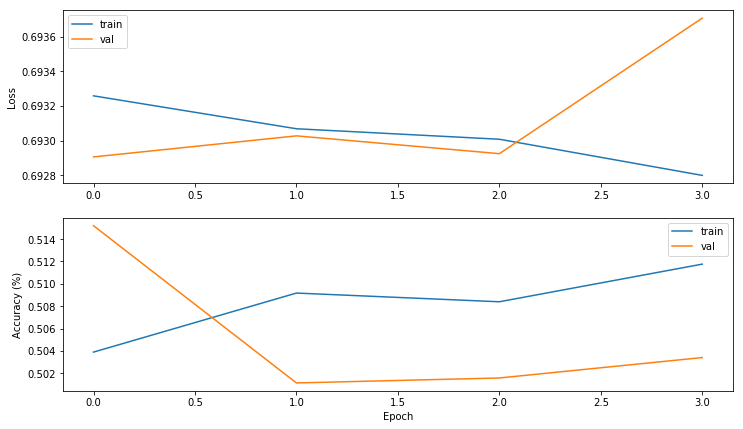

91191/91191 [==============================] - 110s - loss: 0.6928 - acc: 0.5118 - val_loss: 0.6937 - val_acc: 0.5034
Epoch 5/300
83968/91191 [==========================>...] - ETA: 8s - loss: 0.6928 - acc: 0.5132

KeyboardInterrupt: 

In [146]:
model.fit(X_train, y_train_tensor ,callbacks=[checkpointer, plot_losses], 
          #class_weight = {0 : 1.5, 1: 1, 2:2.3, 3:2.3, 4:4},
          epochs=300, batch_size=batch_size, shuffle=True, validation_split=0.1)

In [73]:
best_model = load_model("weights-improvement-classification-0.55.hdf5")

In [75]:
from sklearn import metrics
yp = best_model.predict([X_test], batch_size=batch_size, verbose=1)
ypreds = np.argmax(yp, axis=1) #transform to_categorical labels to one value
print("\n", metrics.accuracy_score(y_test, ypreds))
print (metrics.roc_auc_score(y_test, yp[:,1])) #ROC needs the probs of the positive class ([:,1])

5376/7135 [=====================>........] - ETA: 0s
 0.526419060967
0.536877854045


In [76]:
yp_secret = best_model.predict([X_secret], batch_size=batch_size, verbose=1)
ypreds_secret = np.argmax(yp_secret, axis=1) #transform to_categorical labels to one value
print("\n", metrics.accuracy_score(y_secret, ypreds_secret))
print (metrics.roc_auc_score(y_secret, yp_secret[:,1])) #ROC needs the probs of the positive class ([:,1])

ValueError: Error when checking : expected conv1d_17_input to have 3 dimensions, but got array with shape (4305, 96)

In [ ]:
np.unique(ypreds)

In [ ]:
print (metrics.confusion_matrix(y_test, ypreds))
print (metrics.classification_report(y_test, ypreds))

## Baselines

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

In [ ]:
predicted = model.predict(X_test)
probs = model.predict_proba(X_test)
print (metrics.accuracy_score(y_test, predicted))
print (metrics.roc_auc_score(y_test, probs[:, 1]))

In [ ]:
predicted_secret = model.predict(X_secret)
probs_secret = model.predict_proba(X_secret)
print (metrics.accuracy_score(y_secret, predicted_secret))
print (metrics.roc_auc_score(y_secret, probs_secret[:, 1]))

In [ ]:
print (metrics.confusion_matrix(y_test, predicted))
print (metrics.classification_report(y_test, predicted))

In [ ]:
coefficient = pd.concat([pd.DataFrame(X.columns,columns=['features']),pd.DataFrame(np.transpose(model.coef_))], axis = 1)
display(coefficient.sort_values(0,ascending=False).head(20),coefficient.sort_values(0,ascending=False).tail(20))

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_test, probs[:, 1]) #baseline
fpr2, tpr2, _ = metrics.roc_curve(y_test, yp[:, 1]) #neural network

fpr3, tpr3, _ = metrics.roc_curve(y_secret, probs_secret[:, 1]) #baseline
fpr4, tpr4, _ = metrics.roc_curve(y_secret, yp_secret[:, 1]) #neural network


plt.plot(fpr,tpr, color='crimson', label='baseline') 
plt.plot(fpr3, tpr3, color='crimson', label='baseline (disjoint users)', alpha=0.5)

plt.plot(fpr2,tpr2, color='navy', label='neural network')
plt.plot(fpr4, tpr4, color='navy', label='neural network (disjoint users)',alpha=0.5)

plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='random')
plt.legend(loc="lower right")